In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import functools
from scipy import integrate
import networkx as nx

In [2]:
import os
import math
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

# 1) Generate Random SBM Graphon

In [3]:
def generate_proba_matrix(
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float]
) -> np.ndarray:
    n_groups = np.random.randint(2, max_groups + 1)
    p_intra = np.random.uniform(range_p_intra[0], range_p_intra[1], size=n_groups)
    p = np.random.uniform(range_p_inter[0], range_p_inter[1], size=[n_groups, n_groups])
    np.fill_diagonal(p, p_intra)
    return np.triu(p) + np.triu(p, 1).T

In [4]:
def generate_n_nodes(
    n_groups: int,
    range_n_nodes: List[int]
) -> np.ndarray:
    return np.random.randint(range_n_nodes[0], range_n_nodes[1], n_groups)

In [5]:
def get_graphon_val(
    x: float,
    y: float,
    p: np.ndarray,
    n: np.ndarray
) -> np.ndarray:
    n_nodes = np.sum(n)
    n_nodes_cum = np.cumsum(n)
    
    n_x, n_y = x * n_nodes, y * n_nodes
    i_x, i_y = 0, 0
    while n_x > n_nodes_cum[i_x]:
        i_x += 1
    while n_y > n_nodes_cum[i_y]:
        i_y += 1
    return p[i_x, i_y]

get_graphon = np.vectorize(get_graphon_val, excluded=(2, 3))

In [6]:
def sample_sbm_graphon(
    res: int,
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float],
    range_n_nodes: List[int]
) -> np.ndarray:
    X, Y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    p = generate_proba_matrix(max_groups, range_p_intra, range_p_inter)
    n = generate_n_nodes(p.shape[0], range_n_nodes)
    return get_graphon(X, Y, p, n)

In [7]:
def get_adj(
    n_nodes: int,
    graphon: np.ndarray,
    sort: bool=True,
):
    s = graphon.shape[0]
    
    nodes = np.random.randint(s, size=n_nodes)
    if sort:
        nodes = sorted(nodes)
    
    adj = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            u = nodes[i]
            v = nodes[j]
            
            p = graphon[u, v]
            adj[i, j] = np.random.binomial(n=1, p=p)
    adj += adj.T
    return adj

In [19]:
w = sample_sbm_graphon(
    res=100,
    max_groups=2,
    range_p_intra=[0.5, 0.8],
    range_p_inter=[0.0, 0.05],
    range_n_nodes=[10, 100]
)

In [20]:
adj = get_adj(100, w)
adj_2 = get_adj(100, w, sort=False)

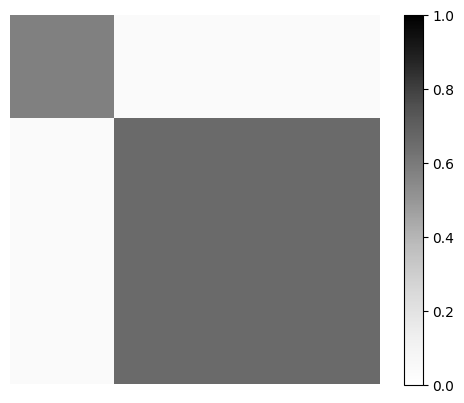

In [21]:
plt.figure()
plt.axis('off')
plt.imshow(w, vmin=0, vmax=1, cmap='Greys')
plt.colorbar()
plt.show()

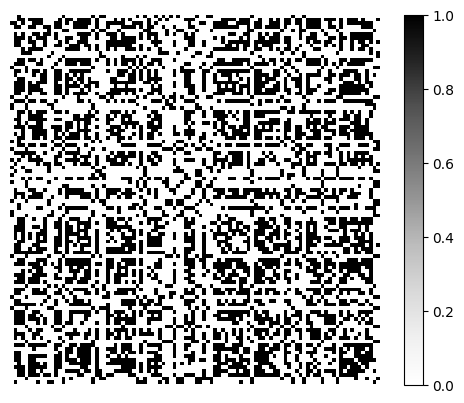

In [22]:
plt.figure()
plt.axis('off')
plt.imshow(adj_2, vmin=0, vmax=1, cmap='Greys')
plt.colorbar()
plt.show()

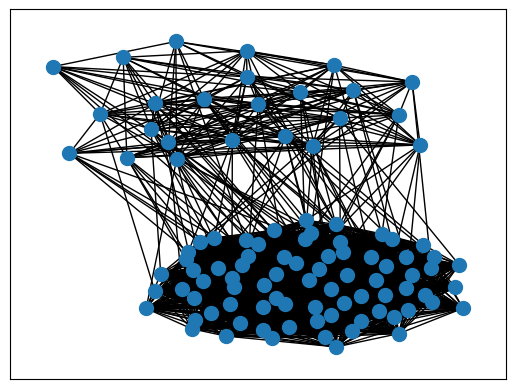

In [23]:
plt.figure()
g = nx.from_numpy_array(adj)
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos, with_labels=False, node_size=100)
plt.show()

# 2) Utils

In [290]:
signal_to_noise_ratio = 0.16
f = 500
num_steps =  500
def pc_sampler(
    score_model, 
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64, 
    num_steps=num_steps, 
    snr=signal_to_noise_ratio,                
    device='cuda',
    eps=1e-3
):
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]

    t = torch.ones(batch_size, device=device)
    noise = torch.randn(batch_size, 28, 28, device=device)
    Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
    S = Z * marginal_prob_std(t)[:, None, None]
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            X = torch.randn(S.shape[0], S.shape[1], f)
            grad = score_model(X, S, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(S.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2

            noise = torch.randn(batch_size, 28, 28, device=device)
            Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
            S = S + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * Z
            #Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            X = torch.randn(S.shape[0], S.shape[1], f)
            S_mean = S + (g**2)[:, None, None] * score_model(X, S, batch_time_step) * step_size

            noise = torch.randn(batch_size, 28, 28, device=device)
            Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
            S = S_mean + torch.sqrt(g**2 * step_size)[:, None, None] * torch.randn_like(S)          
    return S_mean

In [310]:
device = 'cpu'

def marginal_prob_std(t, sigma):   
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

sigma =  25.0
#sigma = 10.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [325]:
def loss_fn(model, S, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(S.shape[0], device=S.device) * (1. - eps) + eps
    std = marginal_prob_std(random_t)

    noise = torch.randn_like(S)
    Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
    perturbed_S = S + Z * std[:, None, None]

    X = torch.randn(S.shape[0], S.shape[1], f)
    score = model(X, perturbed_S, random_t)
    loss = torch.mean(torch.sum((std[:, None, None] * score + Z / std[:, None, None]) ** 2, dim=(1, 2)))
    return loss

In [312]:
def loss_fn(model, S, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(S.shape[0], device=S.device) * (1. - eps) + eps
    std = marginal_prob_std(random_t)

    noise = torch.randn_like(S)
    Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0)) * std[:, None, None] * S
    perturbed_S = S + Z

    X = torch.randn(S.shape[0], S.shape[1], f)
    score = model(X, perturbed_S, random_t)
    loss = torch.mean(torch.sum((std[:, None, None] * score + Z / std[:, None, None]) ** 2, dim=(1, 2)))
    return loss

In [391]:
random_t = torch.rand(1, device=S.device) * (1. - 1e-5) + 1e-5
std = marginal_prob_std_fn(torch.tensor(1))

t = int(10 * random_t.detach().item())

In [419]:
def loss_fn(model, S, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(1, device=S.device) * (1. - eps) + eps
    T = int(10 * random_t.detach().item())

    perturbed_S = S.clone()
    alphas = np.arange(0.0, 1.0, 0.01)[::-1]
    for t, alpha in enumerate(alphas):
        noise = torch.randn_like(S)
        Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
        S_hat = torch.bmm(perturbed_S, perturbed_S) / 30
        perturbed_S = np.sqrt(alpha) * S_hat + np.sqrt(1 - alpha) * Z
        if t == T:
            break

    target_noise = perturbed_S - S

    X = torch.randn(S.shape[0], S.shape[1], f)
    score = model(X, perturbed_S, random_t)
    loss = torch.mean(torch.sum((score - target_noise) ** 2, dim=(1, 2)))
    return loss

In [ ]:
def loss_fn(model, S, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(1, device=S.device) * (1. - eps) + eps
    T = int(10 * random_t.detach().item())

    perturbed_S = S.clone()
    alphas = np.arange(0.0, 1.0, 0.01)[::-1]
    for t, alpha in enumerate(alphas):
        noise = torch.randn_like(S)
        Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
        S_hat = torch.bmm(perturbed_S, perturbed_S) / 30
        perturbed_S = np.sqrt(alpha) * S_hat + np.sqrt(1 - alpha) * Z
        if t == T:
            break

    X = torch.randn(S.shape[0], S.shape[1], f)
    score = model(X, perturbed_S, random_t)
    loss = torch.mean(torch.sum((score + Z) ** 2, dim=(1, 2)))
    return loss

In [313]:
class GNNLayer(nn.Module):
    def __init__(
            self,
            n: int,
            f: int,
            K: int,
        ) -> None:
        super().__init__()
        self.K = K
        self.f = f
        self.n = n

        self.W = nn.Parameter(torch.empty((self.K, self.f, self.f)))
        self.b = nn.Parameter(torch.empty(self.n, self.f))

        torch.nn.init.kaiming_uniform_(self.W.data)
        torch.nn.init.constant_(self.b.data, 0.)

    def forward(
            self,
            X: torch.Tensor,
            S: torch.Tensor,
        ) -> torch.Tensor:
        Z = torch.matmul(X, self.W[0,:,:])
        Sx = X
        for k in range(1, self.K):
            Sx = torch.bmm(S, Sx)
            Z += torch.matmul(Sx, self.W[k,:,:])
        return Z + self.b.unsqueeze(0)


class GNN(nn.Module):
    def __init__(
            self,
            f: int,
            n: int,
            n_layers: int,
            K: int,
            marginal_prob_std,
        ) -> None:

        super().__init__()
        self.n_layers = n_layers
        self.relu = torch.nn.ReLU()
        self.marginal_prob_std = marginal_prob_std

        self.n = n
        self.f = f

        self.gnn_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.gnn_layers.append(GNNLayer(n, f, K))
            self.batch_norm_layers.append(nn.BatchNorm1d(f))
        self.linear_1 = nn.Linear(self.f, self.f)
        self.linear_2 = nn.Linear(self.f, self.n)

    def forward(self, X: torch.Tensor, S: torch.Tensor, t: int) -> torch.Tensor:
        S = self.normalize_S(S)
        for i in range(self.n_layers - 1):
            X = self.gnn_layers[i](X, S)
            X = self.relu(X)
            X = self.batch_norm_layers[i](X.view(-1, self.f)).view(-1, self.n, self.f)
        X =  self.gnn_layers[-1](X, S) / self.marginal_prob_std(t)[:, None, None]
        X = self.relu(X)
        X = self.relu(self.linear_1(X))
        return self.linear_2(X)
        #return torch.bmm(X, X.permute(0, 2, 1))

    def normalize_S(self, S) -> None:
        #unnorm_S = S.data.clone() - S.min()
        #d = unnorm_S.sum(1)
        unnorm_S = S.data.clone()
        d = (unnorm_S + torch.stack([torch.eye(self.n) for _ in range(unnorm_S.shape[0])])).abs().sum(1)
        D_inv = torch.diag_embed(torch.sqrt(1/d))
        D_inv[torch.isinf(D_inv)] = 0.

        S_norm = torch.bmm(D_inv, torch.bmm(unnorm_S, D_inv))

        return S_norm

In [314]:
random_t = torch.rand(S.shape[0], device=S.device) * (1. - 1e-10) + 1e-10
std = marginal_prob_std_fn(random_t)

noise = torch.randn_like(S)
Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
perturbed_S = S + Z * std[:, None, None]

d = (perturbed_S + torch.stack([torch.eye(28) for _ in range(S.shape[0])])).abs().sum(1)
D_inv = torch.diag_embed(torch.sqrt(1 / d))
S_norm = torch.bmm(D_inv, torch.bmm(perturbed_S, D_inv))

In [315]:
S_norm.max()

tensor(0.1982)

In [316]:
random_t = torch.rand(S.shape[0], device=S.device) * (1. - 1e-10) + 1e-10
std = marginal_prob_std_fn(random_t)

noise = torch.randn_like(S)
Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
perturbed_S = S + Z * std[:, None, None]

min_val = perturbed_S.min(dim=1)[0].min(dim=1)[0][:, None, None]
d = (perturbed_S - min_val).sum(1)
D_inv = torch.diag_embed(torch.sqrt(1/d))
S_norm = torch.bmm(D_inv, torch.bmm(perturbed_S, D_inv))
# D_inv[torch.isinf(D_inv)] = 0.

In [334]:
noise = torch.randn_like(S)
Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0)) * std[:S.shape[0], None, None] * S
perturbed_S = S + Z

X = torch.randn(S.shape[0], S.shape[1], f)
score = score_model(X, perturbed_S, random_t[:S.shape[0]])

In [335]:
(score * std[:S.shape[0], None, None])[0][0]

tensor([ 1.4366, -1.0426, -0.6144,  0.2078, -0.8289, -1.1882,  0.9608, -2.6170,
         0.1170, -0.1478, -1.2126, -0.8296, -0.4749,  0.2890,  0.4107,  0.5349,
         0.8463,  0.6438, -0.5997, -0.1452, -0.0718,  0.4794,  0.8680,  0.2082,
        -0.0090, -0.7412, -0.1982,  0.3381], grad_fn=<SelectBackward0>)

In [336]:
(Z / std[:S.shape[0], None, None])[0][0]

tensor([ 0.0000,  0.7960,  0.4101,  0.0240,  0.9691,  1.4171, -0.0000,  2.5405,
        -0.6272, -0.2972,  0.9714,  1.1616, -0.6930, -0.0000, -0.1064, -0.0000,
         0.0000, -0.0000,  0.6213, -0.9150, -0.0000,  0.0000, -0.0000,  0.0000,
        -0.0000, -0.6198,  0.0000, -0.0000])

In [415]:
random_t = torch.rand(1, device=S.device) * (1. - 1e-5) + 1e-5
T = int(10 * random_t.detach().item())
T = 0

perturbed_S = S.clone()
alphas = np.arange(0.0, 1.0, 0.01)[::-1]
for t, alpha in enumerate(alphas):
    noise = torch.randn_like(S)
    Z = (noise + noise.transpose(1, 2)) / torch.sqrt(torch.tensor(2.0))
    S_hat = torch.bmm(perturbed_S, perturbed_S) / 30
    perturbed_S = np.sqrt(alpha) * S_hat + np.sqrt(1 - alpha) * Z
    if t == T:
        break

X = torch.randn(S.shape[0], S.shape[1], f)
score = score_model(X, perturbed_S, random_t)

In [416]:
score[0][0]

tensor([ 8.2925e-01, -3.8281e-01, -3.8776e-01,  1.1270e-01, -7.3909e-01,
        -7.9088e-01, -3.4956e-02, -1.4761e+00, -5.1643e-01, -6.9664e-01,
         1.9663e+00, -4.4170e-01,  1.4083e+00, -9.1015e-01,  2.1195e+00,
         1.9609e-03, -5.9720e-01,  1.4400e+00,  8.3902e-01, -1.3354e+00,
         7.8275e-01, -8.5506e-02, -7.1081e-01, -6.4051e-01,  1.3231e-01,
        -5.4644e-02, -4.0082e-01,  2.2098e-01], grad_fn=<SelectBackward0>)

In [418]:
np.sqrt(1 - alpha) * Z[0][0]

tensor([-0.0999,  0.1085,  0.0990, -0.0093,  0.1361,  0.0959,  0.1317,  0.1940,
         0.1286,  0.0381, -0.1915,  0.0969, -0.1629,  0.1091, -0.2782,  0.0261,
         0.0664, -0.0844, -0.1065,  0.1470, -0.0637,  0.1326,  0.0616,  0.0787,
        -0.0164,  0.0538,  0.0448, -0.0010])

# 3) Training

### 3.1) Ordered

In [28]:
class Graphons(Dataset):
    def __init__(self, sort):
        self.res = 100
        self.nodes = 28
        self.to_tensor = tt.ToTensor()
        self.data = self._generate_data(1_000, sort)

    def _generate_data(self, size, sort):
        data = []
        for _ in range(size):
            w = sample_sbm_graphon(
                res=self.res,
                max_groups=2,
                range_p_intra=[0.6, 0.8],
                range_p_inter=[0.05, 0.1],
                range_n_nodes=[10, 100]
            )
            adj = get_adj(self.nodes, w, sort=sort)            
            data.append(adj)
        return np.array(data).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.to_tensor(self.data[idx]).squeeze()

data = Graphons(sort=True)
loader = DataLoader(data, batch_size=32, shuffle=True)

In [420]:
score_model = torch.nn.DataParallel(GNN(f=f, n=28, n_layers=5, K=5, marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 5000
batch_size =  32
lr=1e-4
losses_0 = []
optimizer = torch.optim.Adamax(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for S in loader:
        S = S.to(device)    
        loss = loss_fn(score_model, S, marginal_prob_std_fn)

        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()

        avg_loss += loss.item() * S.shape[0]
        num_items += S.shape[0]
    losses_0.append(avg_loss / num_items)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/5000 [00:00<?, ?it/s]

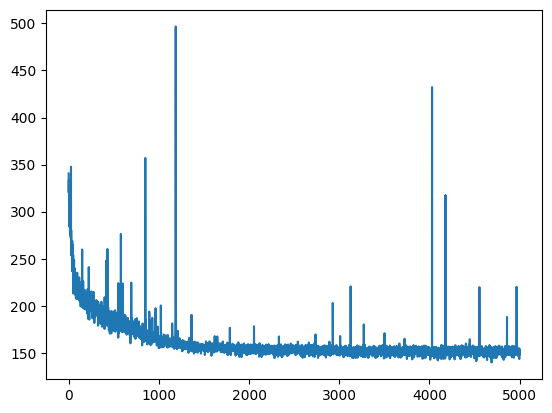

In [421]:
#plt.plot(np.log(losses_0));
plt.plot(losses_0);

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_28399/3606510078.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-762.2601..2511.3652].


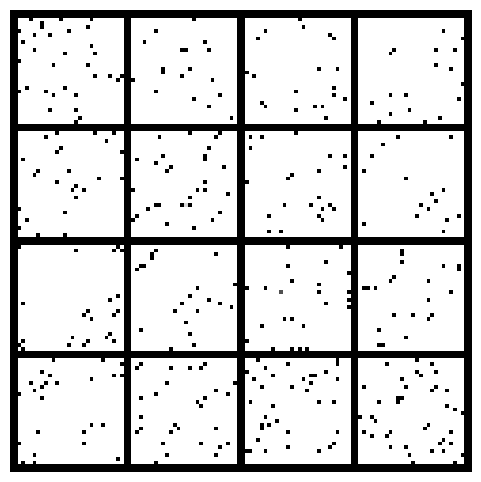

In [144]:
sample_batch_size = 16
sampler = pc_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

#samples = samples.clamp(0.0, 1.0).unsqueeze(1)
samples = samples.unsqueeze(1)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

IndexError: too many indices for tensor of dimension 1

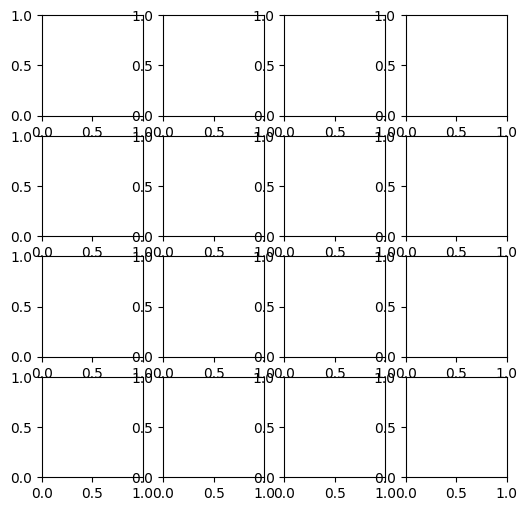

In [145]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, data[i][0], sort=True)
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

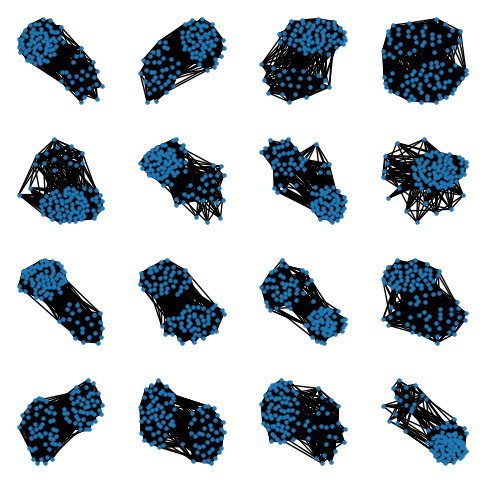

In [ ]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, samples[i, 0])
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

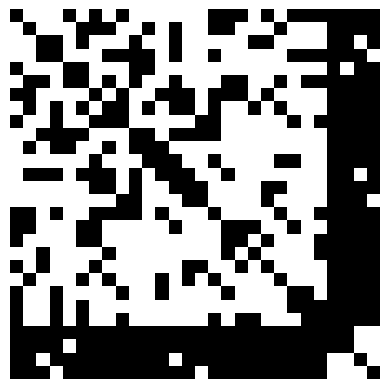

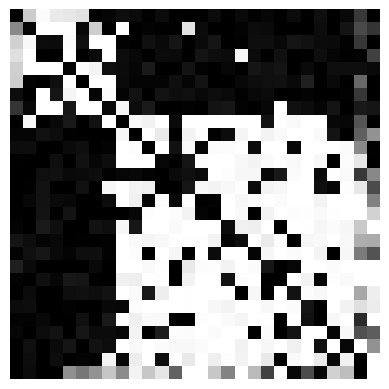

In [ ]:
plt.axis('off')
plt.imshow(x[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

plt.axis('off')
plt.imshow(samples[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

### 3.2) Random

In [ ]:
data = Graphons(sort=False)
loader = DataLoader(data, batch_size=32, shuffle=True)

In [ ]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

In [ ]:
n_epochs = 5_000
batch_size =  32
lr=1e-4

losses_1 = []
optimizer = torch.optim.Adamax(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    losses_1.append(avg_loss / num_items)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_86960/3947096710.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


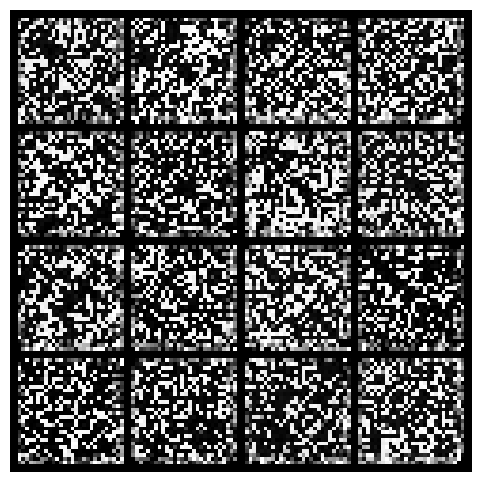

In [ ]:
sample_batch_size = 16
sampler = pc_sampler

samples = sampler(
    score_model, 
    marginal_prob_std_fn,
    diffusion_coeff_fn, 
    sample_batch_size, 
    device=device
)

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

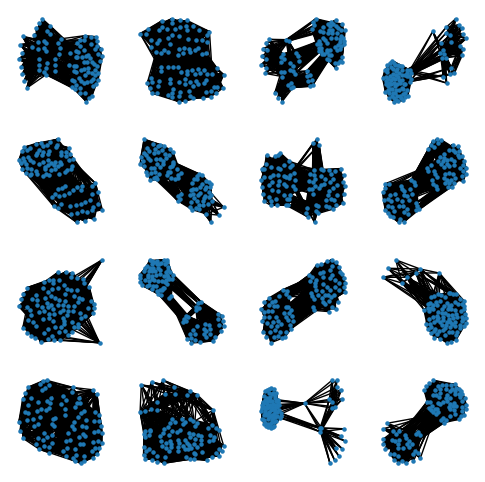

In [ ]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, data[i][0], sort=False)
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

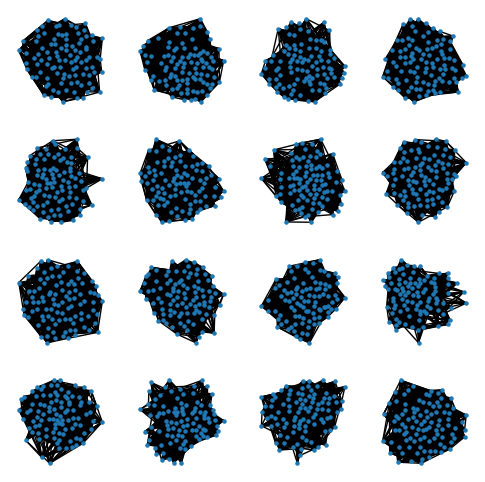

In [ ]:
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    adj = get_adj(100, samples[i, 0], sort=False)
    np.fill_diagonal(adj, 0)
    g = nx.from_numpy_array(adj)
    pos = nx.spring_layout(g)
    nx.draw_networkx(g, ax=ax, pos=pos, with_labels=False, node_size=5)
    ax.axis('off')
plt.show()

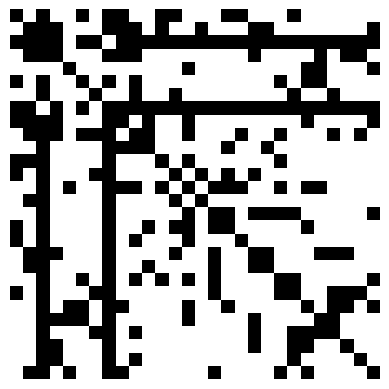

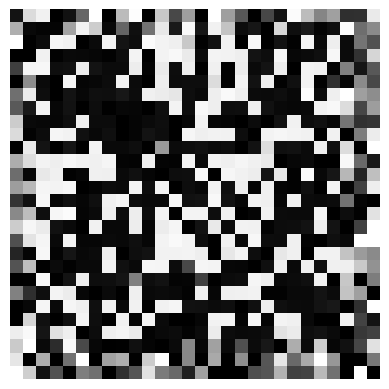

In [ ]:
plt.axis('off')
plt.imshow(x[5, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

plt.axis('off')
plt.imshow(samples[0, 0, :, :], vmin=0, vmax=1.0, cmap='gray')
plt.show()

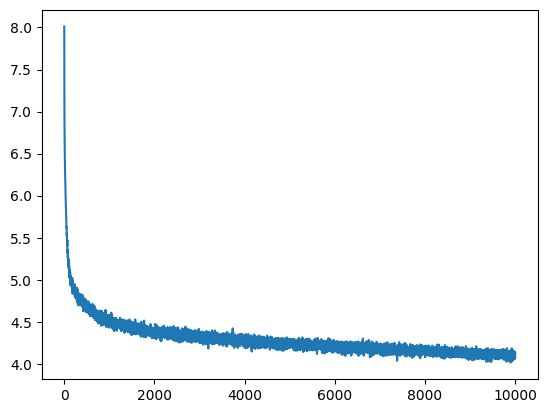

In [ ]:
plt.plot(np.log(losses_0))
#plt.plot(np.log(losses_1))
#plt.ylim(0, 200)

(0.0, 200.0)

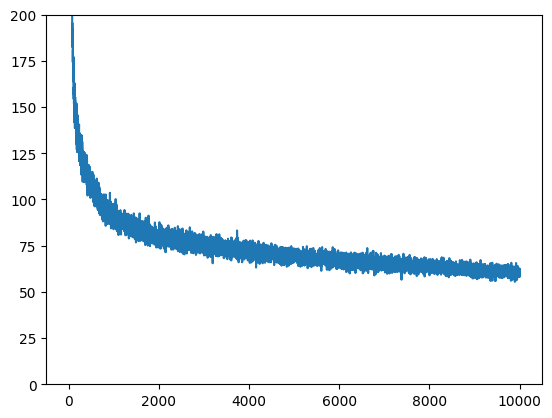

In [ ]:
plt.plot(losses_0)
#plt.plot(losses_1)
plt.ylim(0, 200)

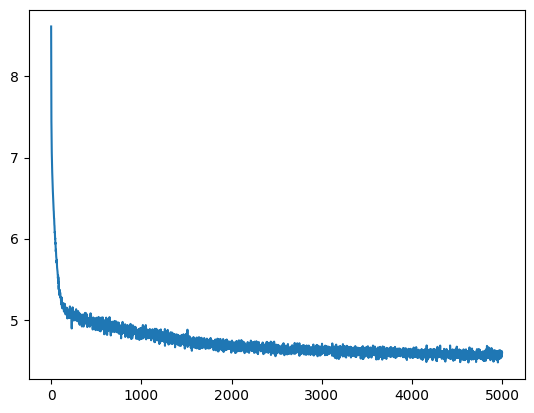

In [ ]:
plt.plot(np.log(losses_1))
#plt.ylim(0, 200)

(0.0, 200.0)

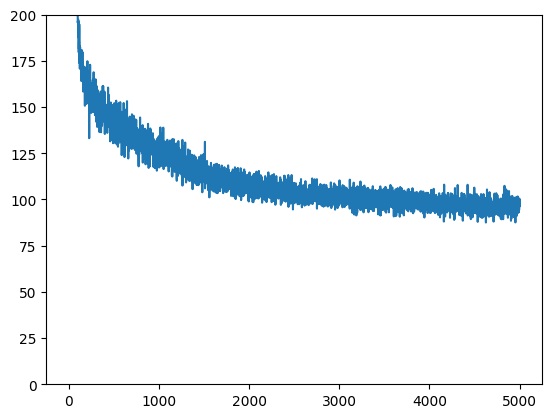

In [ ]:
plt.plot(losses_1)
plt.ylim(0, 200)

In [ ]:
A = np.random.rand(4, 4)
B = np.random.rand(4, 4)
x = np.random.rand(4)

In [ ]:
A @ (- B @ x )

array([-2.76382779, -2.26747552, -3.88669926, -1.78884833])

In [ ]:
- (A @ B) @ x

array([-2.76382779, -2.26747552, -3.88669926, -1.78884833])